## Exploring the variation of SHARP parameters during solar flares

#### Importing libraries

In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from datetime import datetime as dt_obj
import drms
from IPython.display import Image
import matplotlib.pyplot as plt, matplotlib.ticker as mtick
from matplotlib.dates import *
import numpy as np
import pandas as pd
import os.path
import sunpy.map
from sunpy.coordinates import frames
from sunpy.timeseries import TimeSeries
from sunpy.time import TimeRange, parse_time
from sunpy.net import hek, Fido, attrs as a
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Selecting flare events from the HINODE catalog

In [6]:
#===========================================================
datadir = '/media/avijeet/Elements/cnn/sunpy/downloads/'
xmax = 500     # the max distance in arcsec from center in x
ymax = 500     # the max distance in arcsec from center in y
#=============================================================

if not os.path.exists(datadir):
    os.mkdir(datadir)
flares = pd.read_csv(datadir+'xrt_flarecat.csv', index_col = 0)
xflares=flares[flares['class'] > 'X']
xflares.iloc[0,:]

xftab=xflares.iloc[:,[3,4,5,6,7,18]]
xfinal=xftab[(abs(xftab['X']) < xmax) & (abs(xftab['Y']) < ymax) & (xftab['peak'] > '2010/12/31')]
xfinal.shape
print(xfinal)
harp2noaa=datadir+'all_harps_with_noaa_ars.csv'
harps = pd.read_csv(harp2noaa, na_filter= False)
#harps.iloc[0,:];
def find_harp(noaa):
    harpid=harps[(harps['NOAA_ARS'] == noaa) | (harps['ar1'] == noaa)| (harps['ar2'] == noaa)
               | (harps['ar3'] == noaa)| (harps['ar4'] == noaa)| (harps['ar5'] == noaa)]
    harp=harpid['HARPNUM'].values[0]
    return harp

## Selected event details

                    peak    loc1 class      X      Y   region
id                                                           
31070   2011/02/15 01:45  S20W10  X2.2  171.0 -239.0  11158.0
33440   2011/03/09 23:16  N08W11  X1.5  196.0  252.0  11166.0
43810   2011/09/06 22:20  N14W18  X2.1  287.0  124.0  11283.0
43880   2011/09/07 22:38  N14W31  X1.8  482.0  137.0  11283.0
55910   2012/03/07 00:24  N18E31  X5.4 -485.0  397.0  11429.0
55920   2012/03/07 01:14  N15E26  X1.3 -419.0  364.0  11430.0
65220   2012/07/12 16:49  S13W03  X1.4   62.0 -294.0  11520.0
92330   2013/11/08 04:26  S14E15  X1.1 -225.0 -278.0  11890.0
92540   2013/11/10 05:14  S14W13  X1.1  227.0 -280.0  11890.0
96570   2014/01/07 18:32  S15W11  X1.2  137.0 -156.0  11944.0
111580  2014/09/10 17:33  N14E02  X1.6  -89.0   74.0  12158.0
113710  2014/10/22 14:06  S14E13  X1.6 -225.0 -324.0  12192.0
113870  2014/10/24 21:15  S16W21  X3.1  332.0 -265.0  12192.0
113940  2014/10/25 17:08  S10W22  X1.0  365.0 -251.0  12192.0
118000  

In [7]:
#==================
noaa = 11283
#==================

#event = xfinal[xfinal['region']==noaa]
event = xfinal[xfinal['region']==noaa].iloc[[1]] #use iloc index in case of multiple entries
print(event)

                   peak    loc1 class      X      Y   region
id                                                          
43880  2011/09/07 22:38  N14W31  X1.8  482.0  137.0  11283.0


## Input parameters

In [4]:
#--- email registered at JSOC ------
c = drms.Client(email='ap0162@uah.edu', verbose = True)

#--- date and time for plotting full disc HARP image ---
date_im ='2011/09/07'
date_time_im='2011.09.07_22:00:00_TAI'

#--- date and time for GOES X-ray curve --- 
goes_t1 ='2011-09-07 19:00'
goes_t2 ='2011-09-08 01:00'

#--- date and time range for plotting mean alpha with time ---
hmi_ds ='hmi.sharp_cea_720s'
harp = find_harp(noaa)
hmi_time = '[2011.09.07_19:00:00/6h]'
hmi_kw = 'T_REC, MEANALP, ERRALP'

#--- date and time for plotting the Bz from magnetogram ---
ar_time = '[2011.09.07_22:36:00_TAI]'
ar_kw = ['T_REC', 'CROTA2','CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2']
ar_segments = ['Br']

#--- date and time for plotting AIA 171 image ---
aia_ds = 'aia.lev1_euv_12s'
aia_time = '[2011.09.07_22:30:00_TAI]'
aia_wave = 171
aia_segments = ['image']
aia_kw = ['T_REC', 'CROTA2','CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2']

## Image of the SHARP patches on the event day

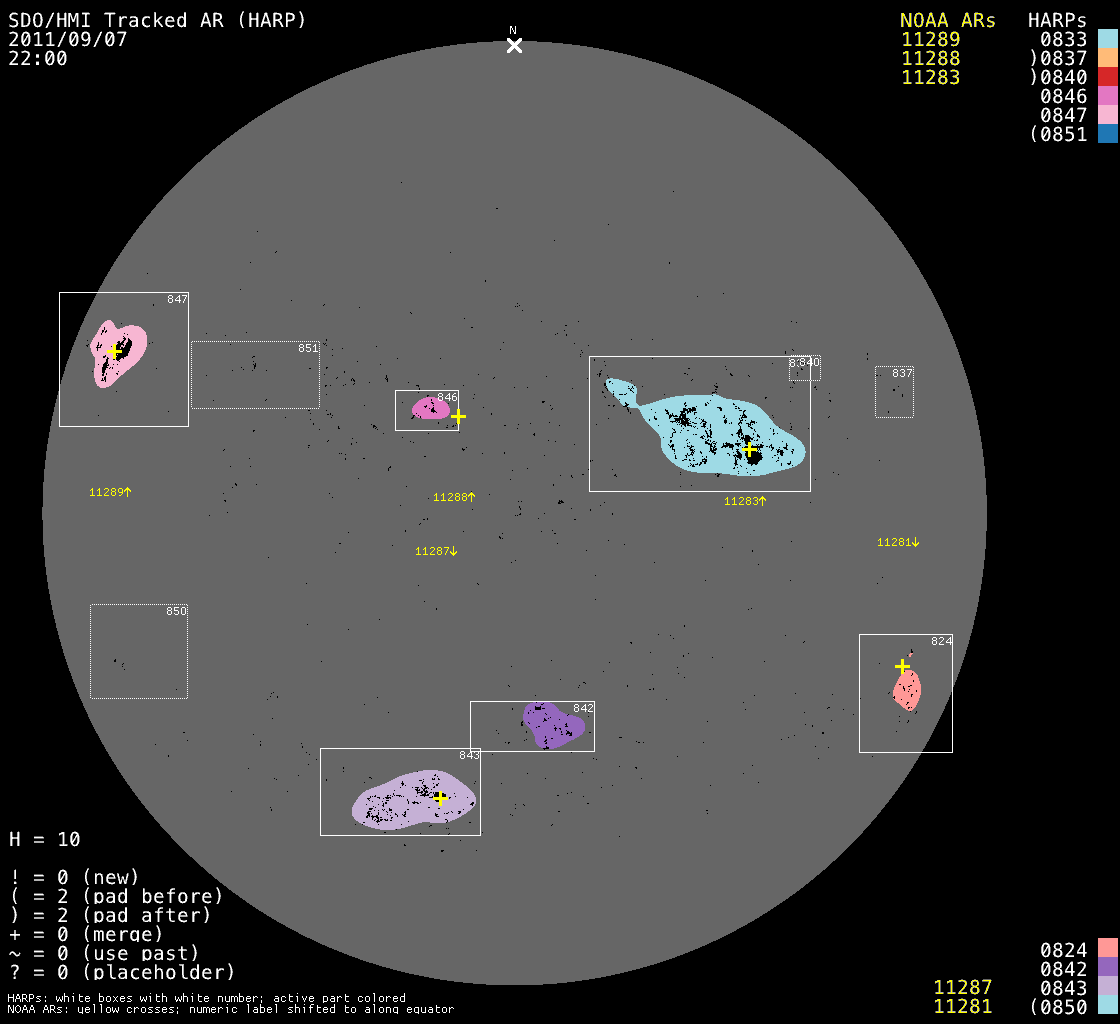

In [5]:
url='http://jsoc.stanford.edu/doc/data/hmi/harp/harp_definitive/'+date_im+'/harp.'+date_time_im+'.png'
Image(url)

#### GOES light curve

In [6]:
#tr = TimeRange(['2011-02-14 22:00', '2011-02-15 05:00'])
tr = TimeRange([goes_t1, goes_t2])
results = Fido.search(a.Time(tr), a.Instrument('XRS'))

#dir(results)

client = hek.HEKClient()
flares_hek = client.search(hek.attrs.Time(tr.start, tr.end),
                           hek.attrs.FL, hek.attrs.FRM.Name == 'SWPC')

files = Fido.fetch(results)
goes = TimeSeries(files)

flares_hek[:]['fl_goescls'];

/home/avijeet/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


In [7]:
tpos=flares_hek[:]['fl_goescls']==event['class'].values[0]
fl_ind, = np.where(tpos == True)
fl_num = fl_ind[0]

In [8]:
goesf = goes[0]
for i in range(1, results.file_num):
    goesf = goesf.concatenate(goes[i])

goes_t = goesf.truncate(tr)

/home/avijeet/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/avijeet/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/avijeet/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/avijeet/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/avijeet/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/avijeet/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/avijeet/an

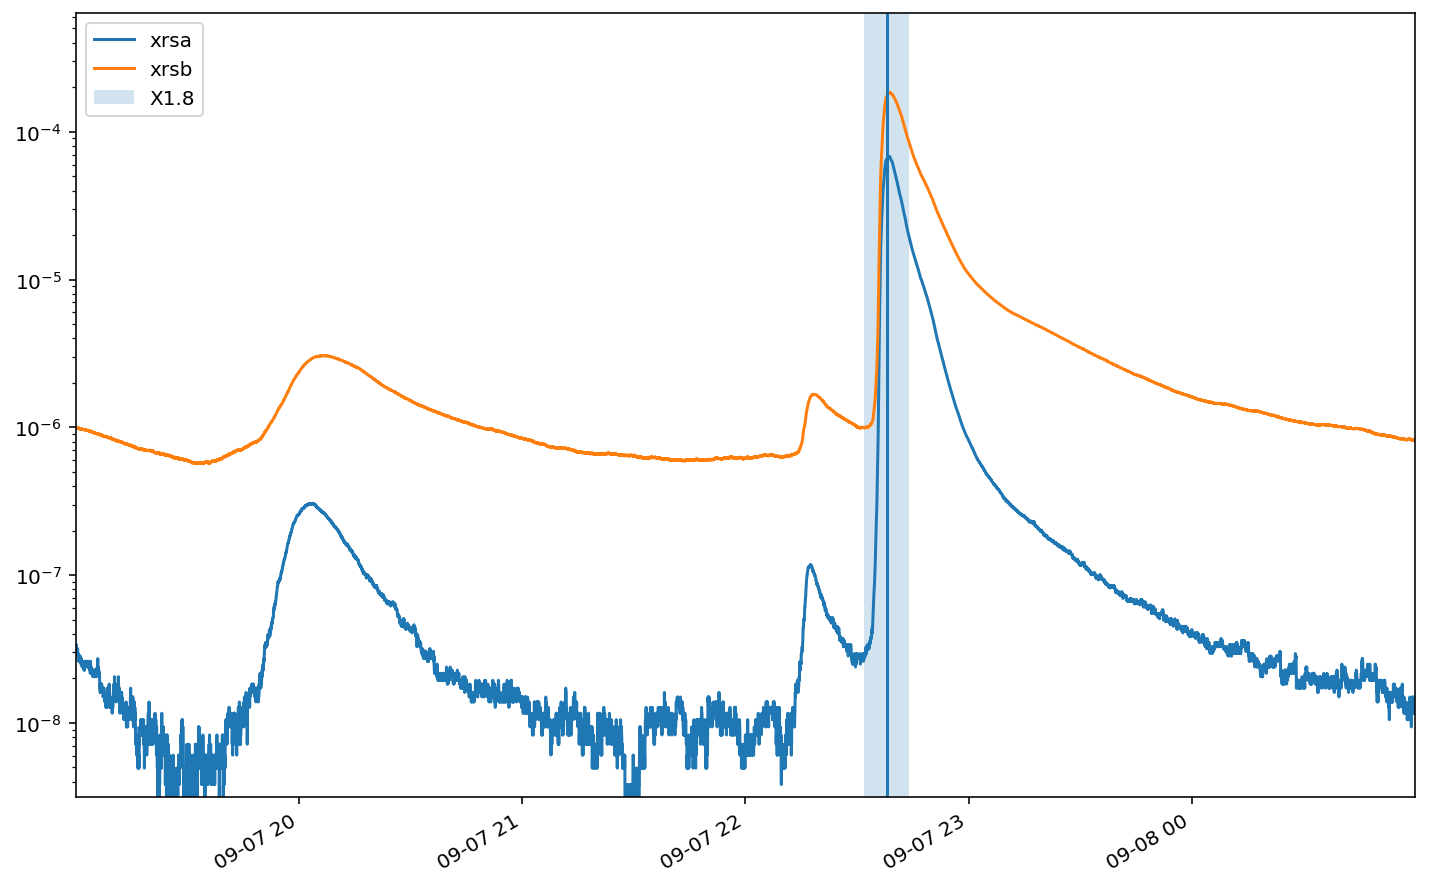

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
goes_t.plot()

ax.axvline(parse_time(flares_hek[fl_num].get('event_peaktime')).plot_date)
ax.axvspan(parse_time(flares_hek[fl_num].get('event_starttime')).plot_date,
           parse_time(flares_hek[fl_num].get('event_endtime')).plot_date,
           alpha=0.2, label=flares_hek[fl_num].get('fl_goescls'))
ax.legend(loc=2)
ax.set_yscale('log')
ax.set_ylim(10**-8.5,10**-3.2)
plt.show()

###  Plotting SHARP parameters

In [10]:
keys, segments = c.query('%s[%d]%s' % (hmi_ds, harp, hmi_time),key=hmi_kw, seg='Br')
#keys, segments = c.query('hmi.sharp_cea_720s[377][2011.02.14_22:00:00/6h]',
#                         key='T_REC, MEANALP, ERRALP', seg='Br')

In [11]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

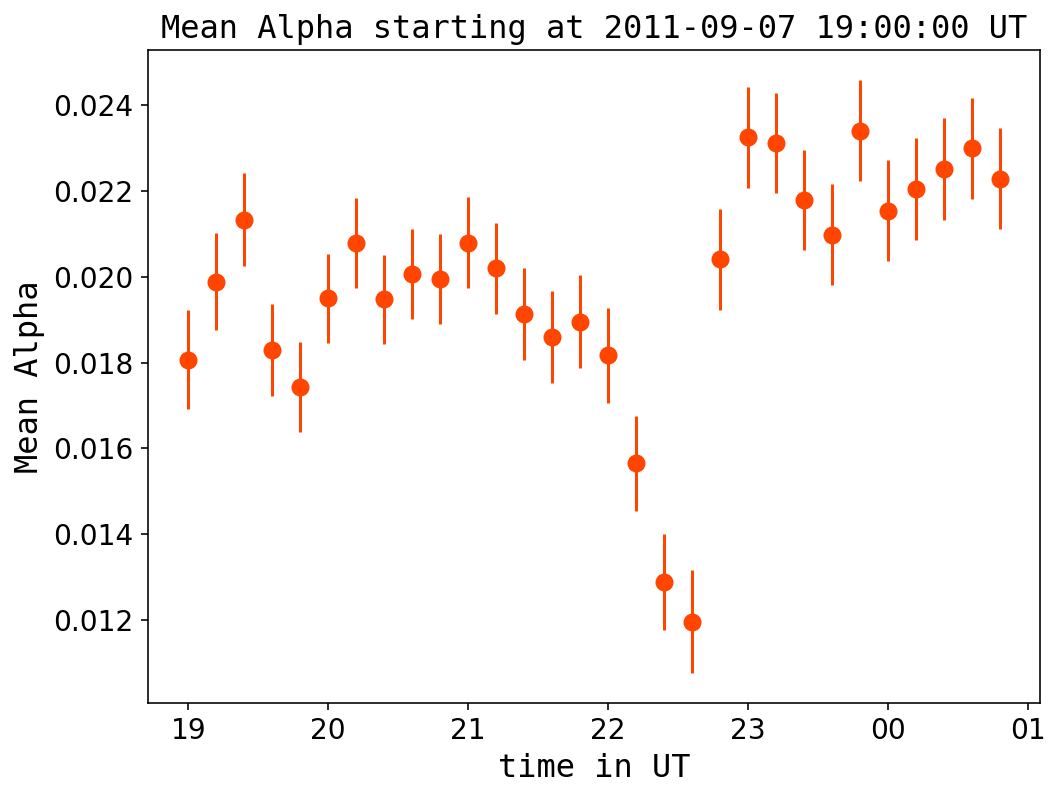

In [12]:
t_rec = np.array([parse_tai_string(keys.T_REC[i],datetime=True) for i in range(keys.T_REC.size)])

fig, ax = plt.subplots(figsize=(8,6))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color

# define some style elements
marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
ax.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

# ascribe the data to the axes
ax.plot(t_rec, (keys.MEANALP),'o',**marker_style)
ax.errorbar(t_rec, (keys.MEANALP), yerr=(keys.ERRALP), linestyle='',color=orangered)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [1] # only show every 1 hours
formatter = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# set yrange 
#ax.set_ylim([2.4,2.8])

# label the axes and the plot
ax.set_xlabel('time in UT',**text_style)
ax.set_ylabel('Mean Alpha',**text_style)
ax.set_title('Mean Alpha starting at '+str(t_rec[0])+' UT',**text_style); # annotate the plot with a start time

### Downloading the HMI Sharp Data

In [13]:
hmi_k = c.query('%s[%d]%s' % (hmi_ds, harp, ar_time), key=ar_kw, rec_index=True)
hmi_si = c.info(hmi_ds)
#si.segments

clon=(hmi_k.CRVAL1[0])
clat=(hmi_k.CRVAL2[0])
ctime=hmi_k.T_REC[0]

nx=(hmi_k.CRPIX1[0]*2)
ny=(hmi_k.CRPIX2[0]*2)

cor = SkyCoord(clon*u.deg, clat*u.deg, frame=frames.HeliographicCarrington,obstime=ctime)
cor

hpc=cor.transform_to(frames.Helioprojective)

In [14]:
req = hmi_k.CRPIX1.idxmin()
exp_query = '%s{%s}' % (req, ','.join(ar_segments))
print(exp_query)
r = c.export(exp_query)

t_rec = drms.to_datetime(hmi_k.T_REC[0])
t_rec_str = t_rec.strftime('%Y%m%d_%H%M%S_TAI')
fname_mask = '{series}.{sharpnum}.{tstr}.{segment}.fits'
fnames = {
    s: fname_mask.format(
        series=hmi_ds, sharpnum=harp, tstr=t_rec_str, segment=s)
    for s in segments}

print(fnames['Br'])
if not os.path.isfile(datadir + fnames['Br']):
    dl = r.download(datadir)

hmi.sharp_cea_720s[833][2011.09.07_22:36:00_TAI]{Br}
hmi.sharp_cea_720s.833.20110907_223600_TAI.Br.fits


###### Read and plots the fits data

In [15]:
def read_fits_data(fname):
    """Reads FITS data and fixes/ignores any non-standard FITS keywords."""
    hdulist = fits.open(fname)
    hdulist.verify('silentfix+warn')
    return hdulist[1].data

(507, 976)


/home/avijeet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.FileIO name='/media/avijeet/Elements/cnn/sunpy/downloads/hmi.sharp_cea_720s.833.20110907_223600_TAI.Br.fits' mode='rb' closefd=True>
  """Entry point for launching an IPython kernel.


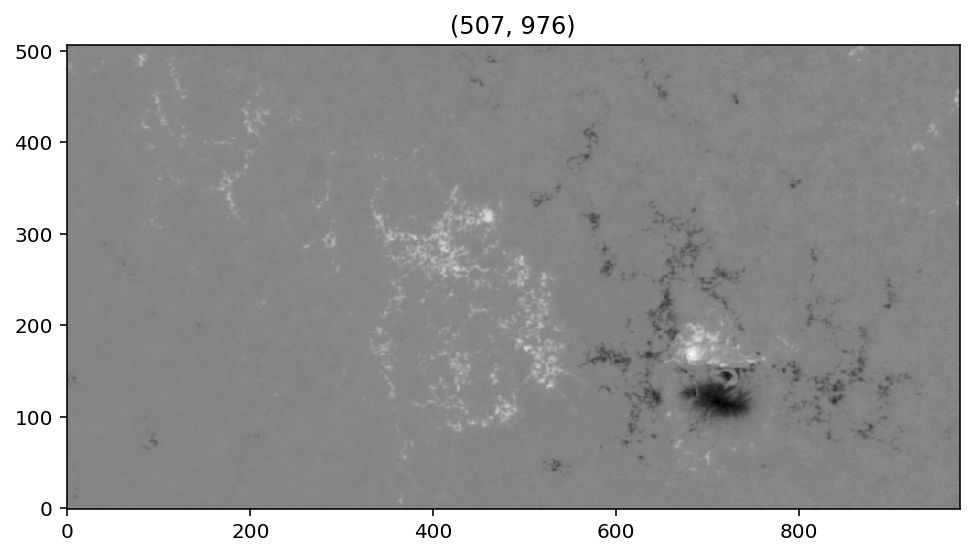

In [16]:
br = read_fits_data(datadir+fnames['Br'])
#bt = read_fits_data(fnames['Bt'])
#bp = read_fits_data(fnames['Bp'])

#bx = bp
#by = -bt
bz = br
print(bz.shape)
fig = plt.figure(figsize=(8,8))
plt.imshow(bz,cmap='gray',origin='lower')
plt.title(bz.shape)
plt.show()

## Cropping of the AR for plotting

/home/avijeet/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/avijeet/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=49>
  source=self)
/home/avijeet/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=48>
  source=self)


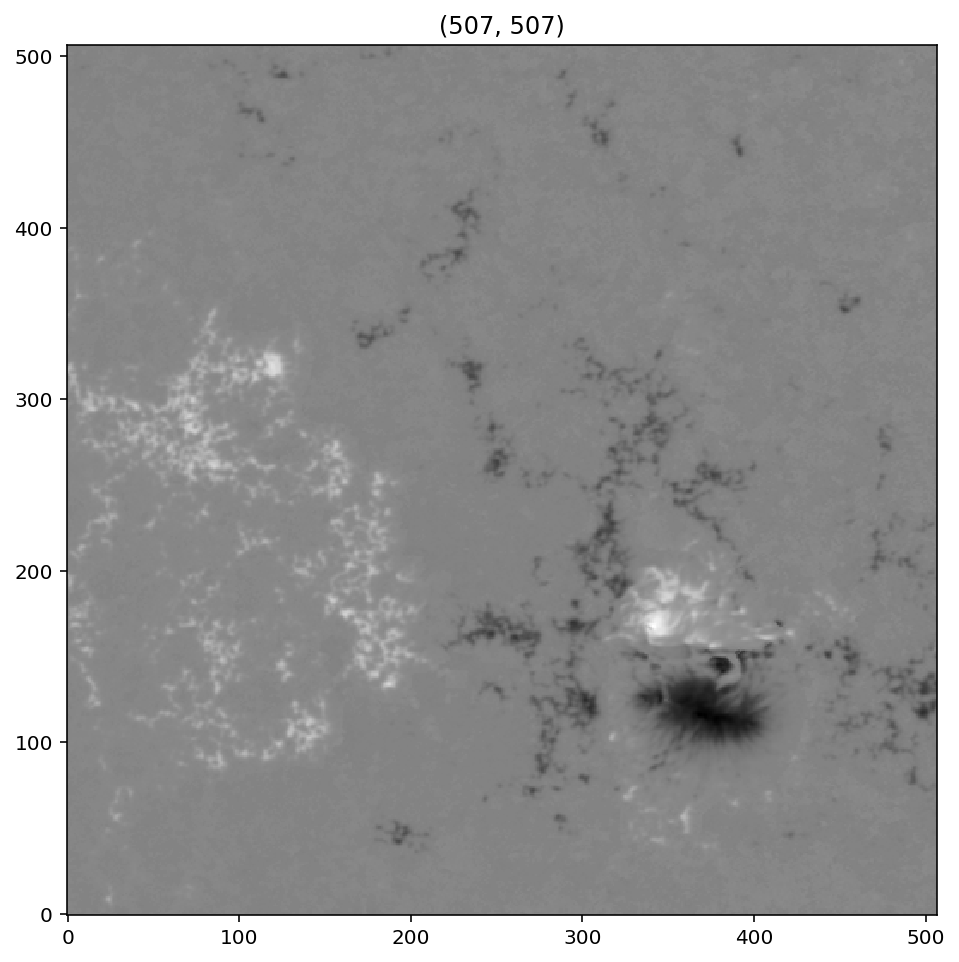

In [17]:
#============= CROP the AR =================
xsize = 507
ysize = 507
yorg = 0
xorg = 340
#===========================================

bzc=bz[yorg:yorg+ysize,xorg:xorg+xsize]
fig = plt.figure(figsize=(8,8))
plt.imshow(bzc,cmap='gray',origin='lower')
plt.title(bzc.shape)
plt.show()

### Downloading AIA data

aia.lev1_euv_12s[2011-09-07T22:29:26Z][171]{image}
aia.lev1_euv_12s.20110907T222926Z.171.image_lev1.fits


/home/avijeet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: ResourceWarning: unclosed file <_io.FileIO name='/media/avijeet/Elements/cnn/sunpy/downloads/aia.lev1_euv_12s.20110907T222926Z.171.image_lev1.fits' mode='rb' closefd=True>


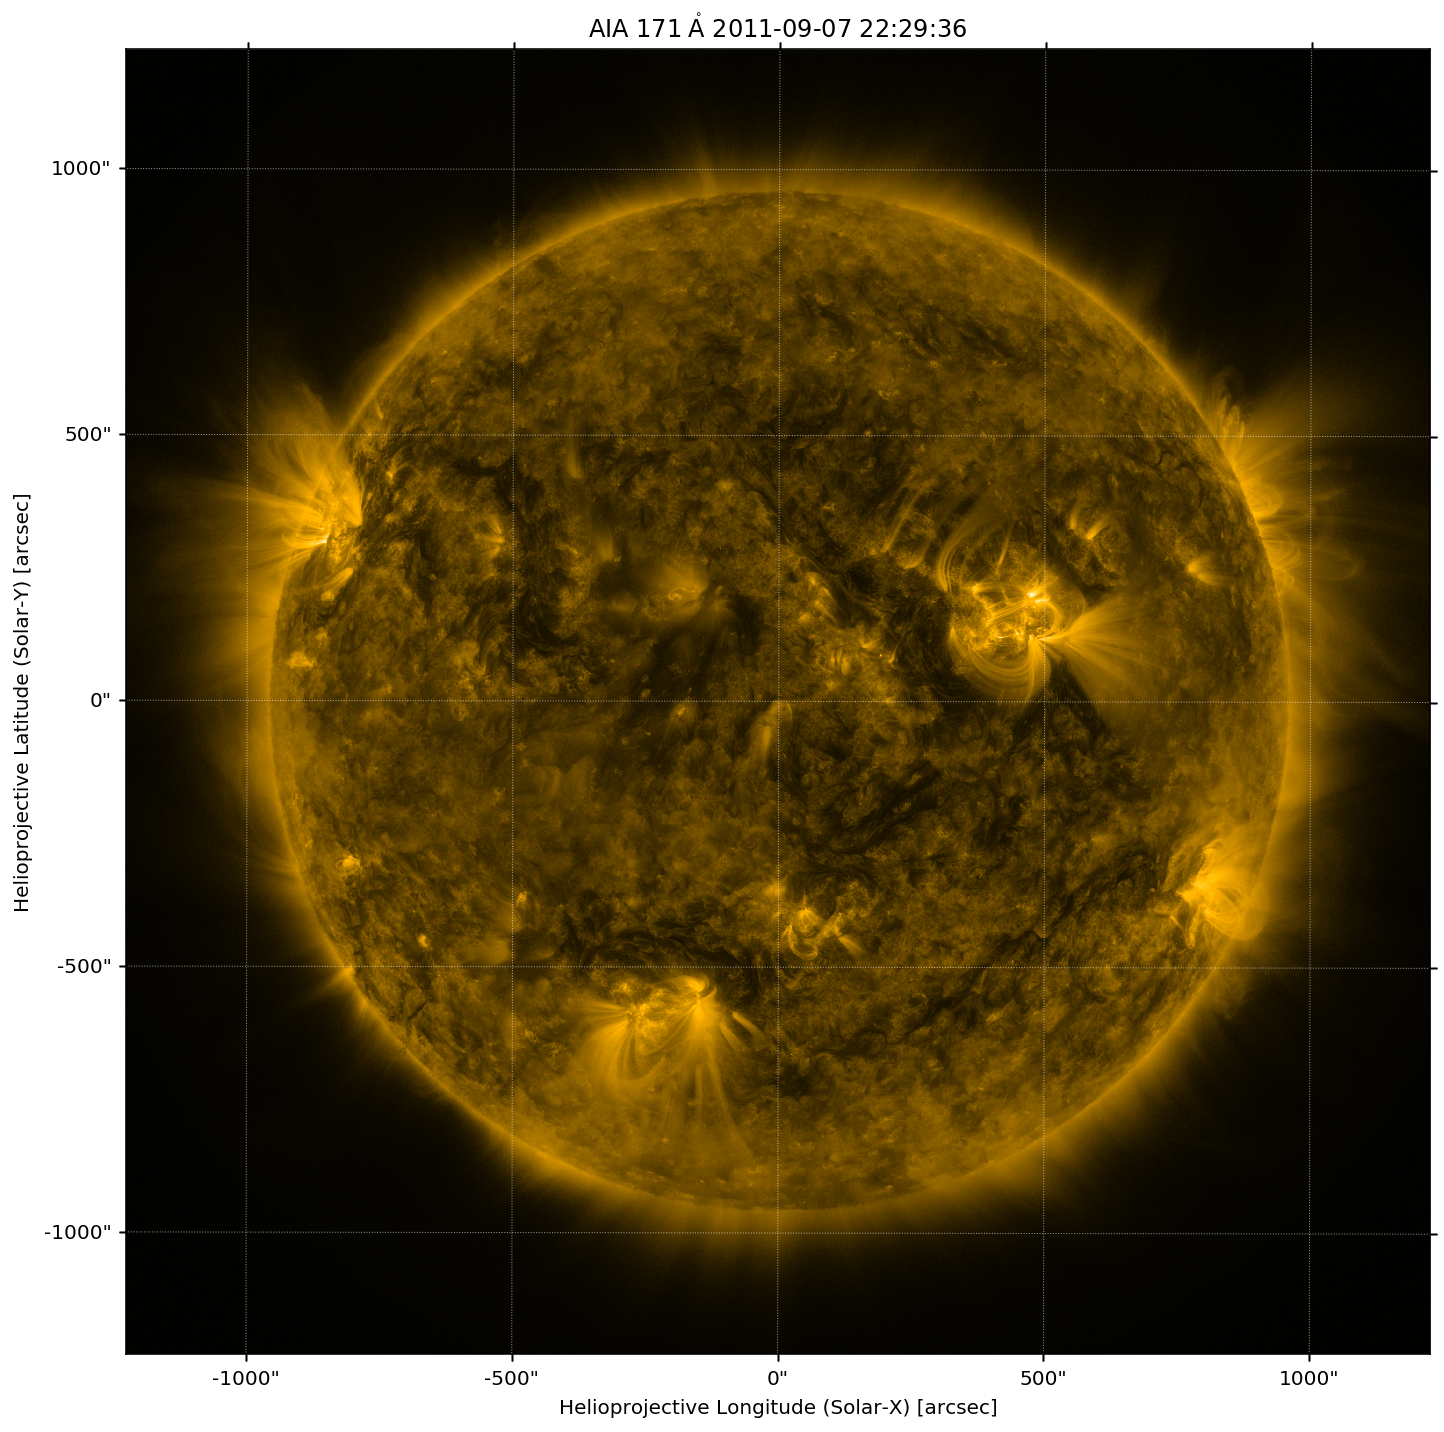

In [18]:
aia_k = c.query('%s%s[%d]' % (aia_ds,aia_time,aia_wave),key=aia_kw, rec_index=True)
aia_si = c.info(aia_ds)
#aia_si.segments

aia_req = aia_k.CRPIX1.idxmin()
aia_exp_query = '%s{%s}' % (aia_req, ','.join(aia_segments))
print(aia_exp_query)

r = c.export(aia_exp_query)

t_rec = drms.to_datetime(aia_k.T_REC[0])

t_rec_str = t_rec.strftime('%Y%m%dT%H%M%SZ')
fname_mask = '{series}.{tstr}.{wave}.{segment}_lev1.fits'
fname_mask

fnames = {
    s: fname_mask.format(
        series=aia_ds, wave=aia_wave, tstr=t_rec_str, segment=s)
    for s in aia_segments}
#fnames

print(fnames['image'])

if not os.path.isfile(datadir + fnames['image']):
    dl = r.download(datadir)

fitsf = fnames['image']
aia = read_fits_data(datadir + fitsf)
aia_map = sunpy.map.Map(datadir + fitsf)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot()
plt.show()


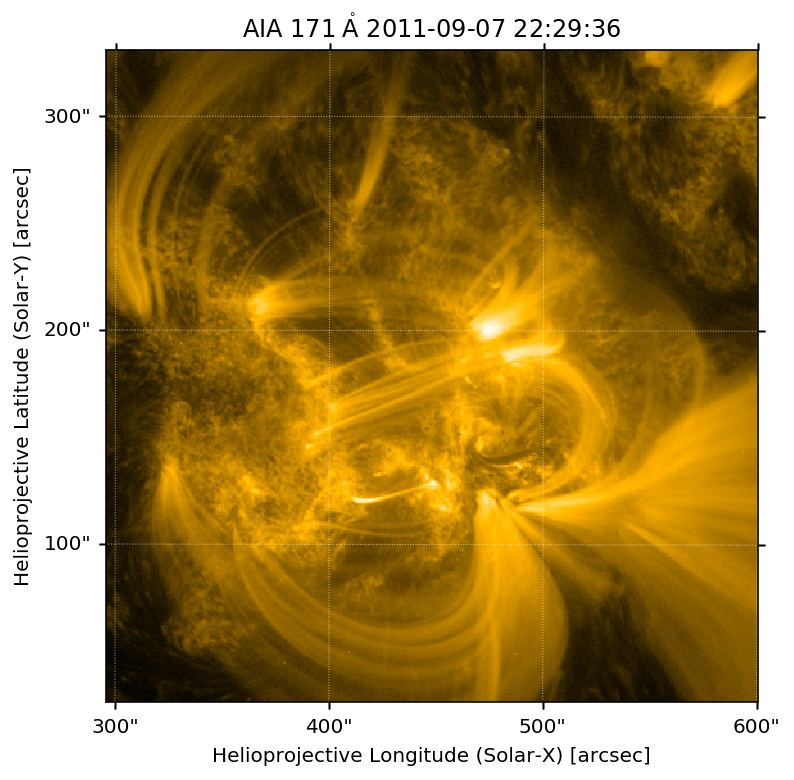

In [19]:
rat = 0.6/0.5
xs=(2*xorg-nx+xsize)/2.
ys=(2*yorg-ny+ysize)/2./2 

top_right = SkyCoord(hpc.Tx+ (xsize/4. +xs/2)*rat * u.arcsec, hpc.Ty+(ysize/4. +ys/2)*rat * u.arcsec, frame=aia_map.coordinate_frame)
bottom_left = SkyCoord(hpc.Tx-(xsize/4.-xs/2)*rat * u.arcsec, hpc.Ty-(ysize/4. -ys/2)*rat * u.arcsec, frame=aia_map.coordinate_frame)

aia_submap = aia_map.submap(bottom_left, top_right)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=aia_submap)
aia_submap.plot()
plt.show()